In [3]:
!pip install akshare

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------- -------------------- 0.5/1.1 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 2.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/13.7 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.7 MB 5.2 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.7 MB 5.7 MB/s eta 0:00:03
   --------- ------------------------------ 3.1/13.7 MB 5.8 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/13.7 MB 5.8 MB/s eta 0:00:02
   ---------------- ----------------------- 5.8/13.7 MB 6.0 MB/s eta 0:00:02
   ------------

  DEPRECATION: Building 'jsonpath' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'jsonpath'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STKAITI' # 中文字体'STKAITI'
plt.rcParams['axes.unicode_minus'] = False
import akshare as ak
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 导入2005年到2025年8月1号的沪深300指数的数据
stock_code = 'sh000300'
start_date = pd.to_datetime('2005-01-01')
end_date = pd.to_datetime('2025-08-01')

price_df = ak.stock_zh_index_daily(symbol=stock_code)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df[(price_df['date'] >= startdate) & (price_df['date'] <= enddate)]
price_df = price_df.sort_values(by='date').set_index('date')
price_df

,open,high,low,close,volume
date,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894
2005-01-05,981.577,997.323,979.877,992.564,711910898
2005-01-06,993.331,993.788,980.330,983.174,628802905
2005-01-07,983.045,995.711,979.812,983.958,729869409
2005-01-10,983.760,993.959,979.789,993.879,579169799
...,...,...,...,...,...
2025-07-24,4116.831,4152.427,4111.885,4149.037,31963239200
2025-07-25,4145.320,4150.499,4117.801,4127.163,27359496300
2025-07-28,4128.199,4146.120,4112.968,4135.824,22275981500


In [ ]:
#计算成交排名，设置窗口大小
N = 40
price_df['volume_rank'] = price_df['volume'].rolling(window=N).apply(lambda x: x.rank().iloc[-1], raw = False)

#标准化成交量排名
price_df['normalized_rank'] = (price_df['volume_rank'] * 2 - ( N + 1)) / (N - 1)
price_df['normalized_rank'] = price_df['normalized_rank'].fillna(0)
price_df

,open,high,low,close,volume,volume_rank,normalized_rank
date,,,,,,,
2005-01-04,994.769,994.769,980.658,982.794,741286894,NaN,0.000000
2005-01-05,981.577,997.323,979.877,992.564,711910898,NaN,0.000000
2005-01-06,993.331,993.788,980.330,983.174,628802905,NaN,0.000000
2005-01-07,983.045,995.711,979.812,983.958,729869409,NaN,0.000000
2005-01-10,983.760,993.959,979.789,993.879,579169799,NaN,0.000000
...,...,...,...,...,...,...,...
2025-07-24,4116.831,4152.427,4111.885,4149.037,31963239200,40.0,1.000000
2025-07-25,4145.320,4150.499,4117.801,4127.163,27359496300,38.0,0.897436
2025-07-28,4128.199,4146.120,4112.968,4135.824,22275981500,34.0,0.692308


In [13]:
# 成交量时序排名择时信号：成交量时序高于s开仓，低于清仓
s = 0.5 #Threshold

timing_df = pd.DataFrame()
timing_df['成交量时序排名'] = (price_df['normalized_rank'] > s) * 1
timing_df['不择时'] = 1
timing_df

,成交量时序排名,不择时
date,,
2005-01-04,0,1
2005-01-05,0,1
2005-01-06,0,1
2005-01-07,0,1
2005-01-10,0,1
...,...,...
2025-07-24,1,1
2025-07-25,1,1
2025-07-28,1,1


In [15]:
# 计算每日收益
price_df['daily returns'] = price_df['close'].pct_change().shift(-1).fillna(0)

# 计算择时后的每日收益
timing_ret = timing_df.mul(price_df['daily returns'], axis=0).dropna()
# 计算累计收益
cum_ret = ( 1 + timing_ret.fillna(0)).cumprod() - 1

cum_ret

,成交量时序排名,不择时
date,,
2005-01-04,0.000000,0.009941
2005-01-05,0.000000,0.000387
2005-01-06,0.000000,0.001184
2005-01-07,0.000000,0.011279
2005-01-10,0.000000,0.014592
...,...,...
2025-07-24,7.965657,3.199418
2025-07-25,7.984472,3.208231
2025-07-28,8.019666,3.224715


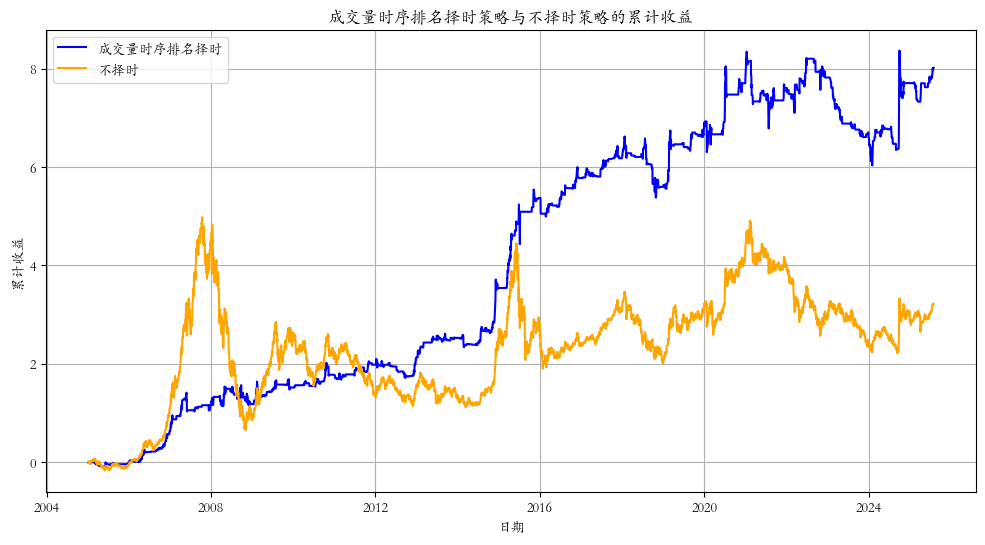

In [18]:
# 可视化输出cum_ret的收益曲线

plt.figure(figsize=(12, 6))
plt.plot(cum_ret.index, cum_ret['成交量时序排名'], label='成交量时序排名择时', color='blue')
plt.plot(cum_ret.index, cum_ret['不择时'], label='不择时', color='orange')
plt.title('成交量时序排名择时策略与不择时策略的累计收益')
plt.xlabel('日期')
plt.ylabel('累计收益')
plt.legend()
plt.grid()
plt.show()